In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import tidy, utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
import pint_pandas
from metpy import constants
from scipy import interpolate
np.set_printoptions(suppress=True,precision=10)

# Open SOS Measurement Dataset, extract measurements

In [2]:
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'
# open files
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit.parquet')
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_planar_fit.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')

In [3]:
tidy_df = tidy_df.set_index(['time','variable'])
tidy_df = tidy_df[~tidy_df.index.duplicated(keep='first')]
tidy_df = tidy_df.reset_index()
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

In [4]:
# ## Add combined blowing snow flux variable
new_bs_var = tidy_df[
        tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])
    ].pivot_table(
        index='time', 
        columns='variable', 
        values='value'
    ).sum(axis=1)
new_bs_var.name = 'SF_avg_ue'
new_bs_var = pd.DataFrame(index=tidy_df.time.unique()).join(pd.DataFrame(new_bs_var))
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    new_bs_var['SF_avg_ue'], 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)

## Add absolute humidity measurements by converting hygrometer measurements

In [5]:
any(tidy_df[tidy_df.measurement=='mixing ratio'].height.unique() == 1)

True

In [6]:
tower_height_keys = tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height']).indices.keys()
for t, h in tower_height_keys:
    this_tower_height_tidy_df = tidy_df.query(
            f"tower == '{t}'"
        ).query(
            f"height == {h}"
        )
    specific_humidity_values = this_tower_height_tidy_df.query(
            "measurement == 'specific humidity'"
        ).set_index('time')[['value']].rename(columns={'value': 'specific humidity'})
    air_density_values = this_tower_height_tidy_df.query(
            "measurement == 'air density'"
        ).set_index('time')[['value']].rename(columns={'value': 'air density'})
    combined_df = specific_humidity_values.join(air_density_values)

    combined_df['abs_humidity'] = (
    # abs_humidity_values = (
        combined_df['specific humidity'].values * units('g/g')
    ).to('g/kg') * (
        combined_df['air density'].values * units('kg/m^3')
    ).m

    tidy_df = tidy.tidy_df_add_variable(
        tidy_df,
        combined_df['abs_humidity'],
        f"absolutehumidity_{int(h)}m_{t}",
        'absolute humidity',
        int(h),
        t
    )

# Calibrate gas analyzer measurements

## Assume that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

In [7]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [8]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [9]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

variable tower  height     value     truth    offset
0    h2o_10m_c     c    10.0  2.524482  2.487502  0.036980
1    h2o_10m_d     d    10.0  1.777035  2.487502 -0.710467
2   h2o_10m_ue    ue    10.0  1.466127  2.487502 -1.021375
3   h2o_10m_uw    uw    10.0  2.096220  2.487502 -0.391282
4    h2o_15m_c     c    15.0  2.289276  2.466260 -0.176984
5     h2o_1m_c     c     1.0  2.840098  2.644000  0.196098
6     h2o_1m_d     d     1.0  2.034612  2.644000 -0.609388
7    h2o_1m_ue    ue     1.0  2.150093  2.644000 -0.493907
8    h2o_1m_uw    uw     1.0  2.425050  2.644000 -0.218950
9    h2o_20m_c     c    20.0  1.255047  2.452636 -1.197588
10    h2o_2m_c     c     2.0  2.379948  2.549800 -0.169851
11    h2o_3m_c     c     3.0  2.203364  2.548130 -0.344766
12    h2o_3m_d     d     3.0  2.220787  2.548130 -0.327344
13   h2o_3m_ue    ue     3.0  2.305036  2.548130 -0.243094
14   h2o_3m_uw    uw     3.0  2.407467  2.548130 -0.140663
15    h2o_5m_c     c     5.0  2.345029  2.512766 -0.167737

## Update dataset with corrections

In [10]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

time    variable     value  height tower  \
34      2022-11-01 00:00:00   h2o_10m_d  1.920190    10.0     d   
169     2022-11-01 00:00:00    h2o_1m_d  2.311011     1.0     d   
219     2022-11-01 00:00:00    h2o_3m_d  2.382047     3.0     d   
310     2022-11-01 00:00:00   h2o_3m_ue  2.575798     3.0    ue   
384     2022-11-01 00:00:00  h2o_10m_uw  2.390329    10.0    uw   
...                     ...         ...       ...     ...   ...   
9556396 2023-06-19 17:30:00    h2o_3m_d  3.101750     3.0     d   
9556418 2023-06-19 17:30:00   h2o_10m_d  2.669686    10.0     d   
9556428 2023-06-19 17:30:00    h2o_3m_c  2.461334     3.0     c   
9556530 2023-06-19 17:30:00   h2o_1m_uw  3.362670     1.0    uw   
9556787 2023-06-19 17:30:00   h2o_10m_c  2.646889    10.0     c   

                 measurement  
34       Water vapor density  
169      Water vapor density  
219      Water vapor density  
310      Water vapor density  
384      Water vapor density  
...                      ...  
9556396  Water vapor density  
9556418  Water vapor density  
9556428  Water vapor density  
9556530  Water vapor density  
9556787  Water vapor density  

[132888 rows x 6 columns]

In [11]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [12]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [13]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [14]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]

alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/796244343.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


# Create wide df

In [15]:
vars = [
    'dir_1m_ue', 'u_h2o__1m_ue', 'v_h2o__1m_ue', 'w_h2o__1m_ue',     'u_1m_ue',  'v_1m_ue',  'w_1m_ue', 
    'dir_3m_ue', 'u_h2o__3m_ue', 'v_h2o__3m_ue', 'w_h2o__3m_ue',     'u_3m_ue',  'v_3m_ue',  'w_3m_ue', 
    'dir_10m_ue', 'u_h2o__10m_ue','v_h2o__10m_ue', 'w_h2o__10m_ue',   'u_10m_ue',  'v_10m_ue', 'w_10m_ue',
    
    'dir_1m_uw', 'u_h2o__1m_uw', 'v_h2o__1m_uw', 'w_h2o__1m_uw',     'u_1m_uw',  'v_1m_uw',  'w_1m_uw', 
    'dir_3m_uw', 'u_h2o__3m_uw', 'v_h2o__3m_uw', 'w_h2o__3m_uw',     'u_3m_uw',  'v_3m_uw',  'w_3m_uw', 
    'dir_10m_uw', 'u_h2o__10m_uw','v_h2o__10m_uw', 'w_h2o__10m_uw',   'u_10m_uw',  'v_10m_uw', 'w_10m_uw',

    'dir_1m_d', 'u_h2o__1m_d', 'v_h2o__1m_d', 'w_h2o__1m_d',        'u_1m_d',   'v_1m_d',   'w_1m_d',  
    'dir_3m_d', 'u_h2o__3m_d', 'v_h2o__3m_d', 'w_h2o__3m_d',        'u_3m_d',   'v_3m_d',   'w_3m_d',  
    'dir_10m_d', 'u_h2o__10m_d','v_h2o__10m_d', 'w_h2o__10m_d',      'u_10m_d',  'v_10m_d',  'w_10m_d', 

    'dir_1m_c', 'u_h2o__1m_c', 'v_h2o__1m_c', 'w_h2o__1m_c',        'u_1m_c',   'v_1m_c',   'w_1m_c',   'specifichumidity_1m_c',    'airdensity_1m_c',
    'dir_2m_c', 'u_h2o__2m_c', 'v_h2o__2m_c', 'w_h2o__2m_c',        'u_2m_c',   'v_2m_c',   'w_2m_c',   'specifichumidity_2m_c',    'airdensity_2m_c',
    'dir_3m_c', 'u_h2o__3m_c', 'v_h2o__3m_c', 'w_h2o__3m_c',        'u_3m_c',   'v_3m_c',   'w_3m_c',   'specifichumidity_3m_c',    'airdensity_3m_c',
    'dir_5m_c', 'u_h2o__5m_c', 'v_h2o__5m_c', 'w_h2o__5m_c',        'u_5m_c',   'v_5m_c',   'w_5m_c',   'specifichumidity_5m_c',    'airdensity_5m_c',
    'dir_10m_c', 'u_h2o__10m_c','v_h2o__10m_c', 'w_h2o__10m_c',      'u_10m_c',  'v_10m_c',  'w_10m_c',  'specifichumidity_10m_c',   'airdensity_10m_c',
    'dir_15m_c', 'u_h2o__15m_c', 'v_h2o__15m_c', 'w_h2o__15m_c',     'u_15m_c',  'v_15m_c',  'w_15m_c',  'specifichumidity_15m_c',   'airdensity_15m_c',
    'dir_20m_c', 'u_h2o__20m_c', 'v_h2o__20m_c', 'w_h2o__20m_c',     'u_20m_c',  'v_20m_c',  'w_20m_c',  'specifichumidity_20m_c',   'airdensity_20m_c',

    'T_1m_c', 'T_2m_c', 'T_3m_c', 'T_4m_c', 'T_5m_c', 'T_6m_c', 'T_7m_c', 'T_8m_c', 'T_9m_c', 'T_10m_c', 
    'T_11m_c', 
    # 'T_12m_c',
      'T_13m_c', 'T_14m_c', 'T_15m_c', 'T_16m_c', 'T_17m_c', 'T_18m_c', 'T_19m_c', 'T_20m_c',

    'Rsw_in_9m_d', 'Rnet_9m_d',

    'SF_avg_ue',

    'Ri_3m_c',

    'L_3m_c',
]

pivot_df = tidy_df[tidy_df.variable.isin(vars)][
    ['time', 'variable', 'value']
].pivot_table(index='time', columns='variable', values='value')


assert len(vars) == len(pivot_df.columns.unique())

# Identify categories for timestamps

In [16]:
# Identify lists of timestamps for different categories
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

december_times = tidy_df[tidy_df.time.dt.month == 12].time
january_times = tidy_df[tidy_df.time.dt.month == 1].time
february_times = tidy_df[tidy_df.time.dt.month == 2].time
march_times = tidy_df[tidy_df.time.dt.month == 3].time
april_times = tidy_df[tidy_df.time.dt.month == 4].time

midwinter_times = tidy_df[tidy_df.time < '20230320'].time
spring_times = tidy_df[tidy_df.time > '20230320'].time

In [17]:
import xarray as xr
precip_df = xr.open_dataset("/Users/elischwat/Development/data/sublimationofsnow/precip_danny/precipitation_rate_gts_w23.nc")['corrected_prcp_rate_m2'].to_dataframe()

is_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 > 0").index.to_series() + dt.timedelta(minutes=30)
])
    
is_not_snowing_dates = pd.concat([
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series(),
    precip_df.query("corrected_prcp_rate_m2 <= 0").index.to_series() + dt.timedelta(minutes=30)
])

# Create table with instrument location info 

We use a file with theodolite/GPS readings provided by NCAR. 

In [18]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/3668931392.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()


x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

# Create tables

## Wind field measurements

In [19]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin([1,3,10])]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-01 00:00:00  0.0865 -0.6910 -0.0048  0.0367 -0.7525 -0.0143  0.0443   
2022-11-01 00:30:00  0.5446 -1.6474 -0.0272  0.5243 -1.4512 -0.0383  0.4868   
2022-11-01 01:00:00  0.5347 -0.8558 -0.0225  0.4851 -0.7126 -0.0315  0.4986   
2022-11-01 01:30:00  0.9003 -1.4851 -0.0329  0.8568 -1.2744 -0.0305  0.8835   
2022-11-01 02:00:00  0.9737 -1.7045 -0.0351  1.0094 -1.5008 -0.0412  0.9482   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-01 00:00:00 -0.6557 -0.0172 -0.0318  ... -0.0626  0.4104 -0.2787   
2022-11-01 00:30:00 -1.5875 -0.0174 -0.0000  ... -0.0842  1.9957 -1.7328   
2022-11-01 01:00:00 -0.7828 -0.0221  0.0892  ... -0.0970  1.8366 -1.0534   
2022-11-01 01:30:00 -1.2990 -0.0385  0.1971  ... -0.1606  1.9838 -1.4107   
2022-11-01 02:00:00 -1.5199 -0.0352  0.1893  ... -0.1807  2.1555 -1.7669   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-01 00:00:00  0.0306  0.2659 -0.1334 -0.0142  0.4171 -0.3486 -0.0254  
2022-11-01 00:30:00  0.0261  1.7225 -1.8312 -0.0428  1.4679 -2.1719 -0.0229  
2022-11-01 01:00:00 -0.0035  1.6724 -1.1870 -0.0307  1.4774 -1.5447 -0.0597  
2022-11-01 01:30:00 -0.0383  1.7846 -1.4234 -0.1170  1.5772 -1.9734 -0.0990  
2022-11-01 02:00:00 -0.0610  1.9922 -1.8659 -0.1581  1.6967 -2.4583 -0.1315  

[5 rows x 36 columns]

## Turbulent water vapor flux measurements

In [20]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin([1,3,10])]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df.head()

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-01 00:00:00 -0.0024 -0.0017 -0.0002  0.0022 -0.0041 -0.0001 -0.0014   
2022-11-01 00:30:00  0.0064 -0.0000 -0.0005  0.0044 -0.0008 -0.0002  0.0071   
2022-11-01 01:00:00  0.0007 -0.0005 -0.0005 -0.0001 -0.0002 -0.0004  0.0020   
2022-11-01 01:30:00 -0.0002 -0.0014 -0.0007  0.0001 -0.0021 -0.0005  0.0004   
2022-11-01 02:00:00  0.0015 -0.0078 -0.0010  0.0023 -0.0087 -0.0007  0.0045   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-01 00:00:00 -0.0013 -0.0001  0.0011  ... -0.0018  0.0056  0.0038   
2022-11-01 00:30:00  0.0035 -0.0002 -0.0030  ... -0.0003 -0.0037  0.0043   
2022-11-01 01:00:00  0.0033 -0.0003 -0.0000  ... -0.0012  0.0053 -0.0015   
2022-11-01 01:30:00 -0.0005 -0.0004 -0.0001  ... -0.0005  0.0009  0.0006   
2022-11-01 02:00:00 -0.0046 -0.0007 -0.0053  ... -0.0015  0.0055 -0.0036   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-01 00:00:00 -0.0012  0.0062  0.0114 -0.0013  0.0021  0.0031 -0.0002  
2022-11-01 00:30:00 -0.0002 -0.0089  0.0163 -0.0005 -0.0030  0.0064 -0.0003  
2022-11-01 01:00:00 -0.0004  0.0078  0.0003 -0.0010  0.0071 -0.0062 -0.0009  
2022-11-01 01:30:00 -0.0003  0.0037 -0.0014 -0.0002  0.0004  0.0015 -0.0005  
2022-11-01 02:00:00 -0.0003  0.0128 -0.0085 -0.0012  0.0078 -0.0073 -0.0009  

[5 rows x 36 columns]

## Humidity measurements

In [21]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df[abs_hum_field_df.height == 1]

time   variable     value  height tower  \
699     2022-11-01 00:00:00   h2o_1m_c  2.386796     1.0     c   
983     2022-11-01 00:30:00   h2o_1m_c  2.360473     1.0     c   
2398    2022-11-01 01:00:00   h2o_1m_c  2.366735     1.0     c   
3306    2022-11-01 01:30:00   h2o_1m_c  2.336685     1.0     c   
3979    2022-11-01 02:00:00   h2o_1m_c  2.330124     1.0     c   
...                     ...        ...       ...     ...   ...   
9553058 2023-06-19 15:30:00  h2o_1m_uw  3.714206     1.0    uw   
9553881 2023-06-19 16:00:00  h2o_1m_uw  4.011180     1.0    uw   
9555005 2023-06-19 16:30:00  h2o_1m_uw  3.618739     1.0    uw   
9555736 2023-06-19 17:00:00  h2o_1m_uw  3.705095     1.0    uw   
9556530 2023-06-19 17:30:00  h2o_1m_uw  3.581620     1.0    uw   

                 measurement  
699      Water vapor density  
983      Water vapor density  
2398     Water vapor density  
3306     Water vapor density  
3979     Water vapor density  
...                      ...  
9553058  Water vapor density  
9553881  Water vapor density  
9555005  Water vapor density  
9555736  Water vapor density  
9556530  Water vapor density  

[44296 rows x 6 columns]

In [22]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin([1,3,10])]
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

height                             1.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-01 00:00:00              2.3868              2.9204   
2022-11-01 00:30:00              2.3605              2.9037   
2022-11-01 01:00:00              2.3667              2.9127   
2022-11-01 01:30:00              2.3367              2.8855   
2022-11-01 02:00:00              2.3301              2.8820   
...                                 ...                 ...   
2023-06-19 15:30:00              3.1975              2.8890   
2023-06-19 16:00:00              3.5361              3.1041   
2023-06-19 16:30:00              3.2706              2.7884   
2023-06-19 17:00:00              3.4169              2.9184   
2023-06-19 17:30:00              3.2861              2.8741   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-01 00:00:00              2.5269              2.7747   
2022-11-01 00:30:00              2.4873              2.7864   
2022-11-01 01:00:00              2.4927              2.7671   
2022-11-01 01:30:00              2.4619              2.7326   
2022-11-01 02:00:00              2.4483              2.7327   
...                                 ...                 ...   
2023-06-19 15:30:00              3.8793              3.7142   
2023-06-19 16:00:00              4.1882              4.0112   
2023-06-19 16:30:00              3.8645              3.6187   
2023-06-19 17:00:00              4.0180              3.7051   
2023-06-19 17:30:00              3.9490              3.5816   

height                             3.0                       \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-01 00:00:00              2.8564              2.7094   
2022-11-01 00:30:00              2.8324              2.6924   
2022-11-01 01:00:00              2.8426              2.6844   
2022-11-01 01:30:00              2.8180              2.6584   
2022-11-01 02:00:00              2.8084              2.6481   
...                                 ...                 ...   
2023-06-19 15:30:00              2.6272              3.2356   
2023-06-19 16:00:00              2.9380              3.4930   
2023-06-19 16:30:00              2.7885              3.2903   
2023-06-19 17:00:00              2.8934              3.4355   
2023-06-19 17:30:00              2.8061              3.4291   

height                                                       \
tower                                ue                  uw   
measurement         Water vapor density Water vapor density   
time                                                          
2022-11-01 00:00:00              2.8189              2.8137   
2022-11-01 00:30:00              2.8086              2.7926   
2022-11-01 01:00:00              2.7958              2.7863   
2022-11-01 01:30:00              2.7707              2.7519   
2022-11-01 02:00:00              2.7584              2.7498   
...                                 ...                 ...   
2023-06-19 15:30:00              3.0312              3.0504   
2023-06-19 16:00:00              3.3349              3.4721   
2023-06-19 16:30:00              3.1489              3.2402   
2023-06-19 17:00:00              3.2753              3.3384   
2023-06-19 17:30:00              3.2620              3.2189   

height                             10.0                      \
tower                                 c                   d   
measurement         Water vapor density Water vapor density   
time                       

## Advective flux measurements

In [23]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['u'] = this_wind_df['u']*this_abs_hum_df['Water vapor density']
        this_wind_df['v'] = this_wind_df['v']*this_abs_hum_df['Water vapor density']
        this_wind_df['w'] = this_wind_df['w']*this_abs_hum_df['Water vapor density']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new)

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df.head()

height                   1.0                                           \
tower                       c                             d             
measurement                 u         v         w         u         v   
time                                                                    
2022-11-01 00:00:00  0.206458 -1.649279 -0.011457  0.107179 -2.197601   
2022-11-01 00:30:00  1.285528 -3.888688 -0.064206  1.522410 -4.213849   
2022-11-01 01:00:00  1.265474 -2.025422 -0.053251  1.412951 -2.075590   
2022-11-01 01:30:00  2.103731 -3.470233 -0.076877  2.472296 -3.677281   
2022-11-01 02:00:00  2.268818 -3.971655 -0.081787  2.909091 -4.325306   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                 w         u         v         w         u  ...   
time                                                                   ...   
2022-11-01 00:00:00 -0.041762  0.111942 -1.656888 -0.043463 -0.088235  ...   
2022-11-01 00:30:00 -0.111212  1.210818 -3.948589 -0.043279 -0.000000  ...   
2022-11-01 01:00:00 -0.091750  1.242860 -1.951286 -0.055089  0.246825  ...   
2022-11-01 01:30:00 -0.088008  2.175089 -3.198008 -0.094783  0.538595  ...   
2022-11-01 02:00:00 -0.118738  2.321478 -3.721171 -0.086180  0.517300  ...   

height                   10.0                                          \
tower                       c         d                            ue   
measurement                 w         u         v         w         u   
time                                                                    
2022-11-01 00:00:00 -0.174041  1.079639 -0.733176  0.080499  0.744600   
2022-11-01 00:30:00 -0.233823  5.252283 -4.560383  0.068690  4.779937   
2022-11-01 01:00:00 -0.269107  4.795546 -2.750533 -0.009139  4.643419   
2022-11-01 01:30:00 -0.442646  5.164625 -3.672616 -0.099710  4.906222   
2022-11-01 02:00:00 -0.494323  5.559897 -4.557542 -0.157343  5.445280   

height                                                                 
tower                                          uw                      
measurement                 v         w         u         v         w  
time                                                                   
2022-11-01 00:00:00 -0.373560 -0.039764  1.160205 -0.969666 -0.070653  
2022-11-01 00:30:00 -5.081580 -0.118770  4.090744 -6.052651 -0.063818  
2022-11-01 01:00:00 -3.295705 -0.085239  4.084863 -4.270941 -0.165065  
2022-11-01 01:30:00 -3.913211 -0.321656  4.354334 -5.448163 -0.273319  
2022-11-01 02:00:00 -5.100064 -0.432135  4.647940 -6.734267 -0.360231  

[5 rows x 36 columns]

# Create an interpolated wind field from measurements

## 2D example

In [24]:
wind_field_df.iloc[0][3]

tower  measurement
c      u              0.2444
       v             -0.6054
       w             -0.0240
d      u              0.2502
       v             -0.6531
       w             -0.0315
ue     u              0.1007
       v             -0.5945
       w             -0.0383
uw     u              0.1448
       v             -0.7532
       w              0.0175
Name: 2022-11-01 00:00:00, dtype: float64

In [25]:
def divergence_2d(field):
    "return the divergence of a n-D field"
    return np.sum(np.gradient(field),axis=0)

In [26]:

# for i in [0,10,5]:
divergences_dict = {}
for HEIGHT in [1,3,10]:
    divergences_ls = []
    for i in wind_field_df.index:
        
        x = instrument_loc_df.loc[(HEIGHT)][['x']]
        y = instrument_loc_df.loc[(HEIGHT)][['y']]

        wind_field_vals = pd.DataFrame(wind_field_df.loc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
        wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
        points_and_wind_fields = x.join(y).join(wind_field_vals)
        xx = np.linspace(
            points_and_wind_fields.x.min(), 
            points_and_wind_fields.x.max(), 50
        )
        yy = np.linspace(
            points_and_wind_fields.y.min(), 
            points_and_wind_fields.y.max(), 50
        )
        xx, yy = np.meshgrid(xx, yy)
        points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
        u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
        v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

        F = np.array([u_interp, v_interp])
        div = divergence_2d(F)
        divergences_ls.append(div)
        
    divergences_dict[HEIGHT] = divergences_ls

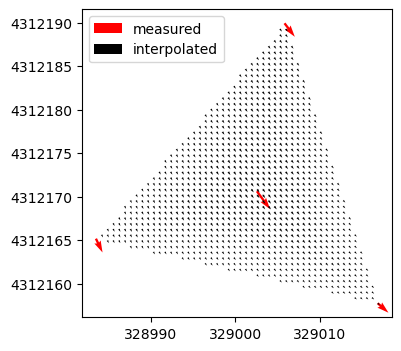

In [27]:
# we just have one density measurement at this height, so simply spread the
# measured density value across all the points
# rho_interp = np.full(u_interp.shape, src_3_c_density[i][0])

HEIGHT = 3
i = '2022-12-22 03:00:00'

x = instrument_loc_df.loc[(HEIGHT)][['x']]
y = instrument_loc_df.loc[(HEIGHT)][['y']]

wind_field_vals = pd.DataFrame(wind_field_df.loc[i][HEIGHT]).reset_index().set_index('tower').pivot(columns='measurement')
wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
points_and_wind_fields = x.join(y).join(wind_field_vals)
xx = np.linspace(
    points_and_wind_fields.x.min(), 
    points_and_wind_fields.x.max(), 50
)
yy = np.linspace(
    points_and_wind_fields.y.min(), 
    points_and_wind_fields.y.max(), 50
)
xx, yy = np.meshgrid(xx, yy)
points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y)))
u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy), method='linear')
v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy), method='linear')

fig, ax = plt.subplots(figsize=(4,4))
ax.quiver(
    points_and_wind_fields.x,
    points_and_wind_fields.y,
    points_and_wind_fields.u,
    points_and_wind_fields.v,
    color='red', 
    label='measured'
)
ax.ticklabel_format(useOffset=False, style='plain')
ax.quiver(xx, yy, u_interp, v_interp, label='interpolated')
ax.ticklabel_format(useOffset=False, style='plain')
ax.legend(loc='upper left')

In [46]:
u_interp[:,30], v_interp[:,30]

IndexError: index 30 is out of bounds for axis 1 with size 25

## 3D example

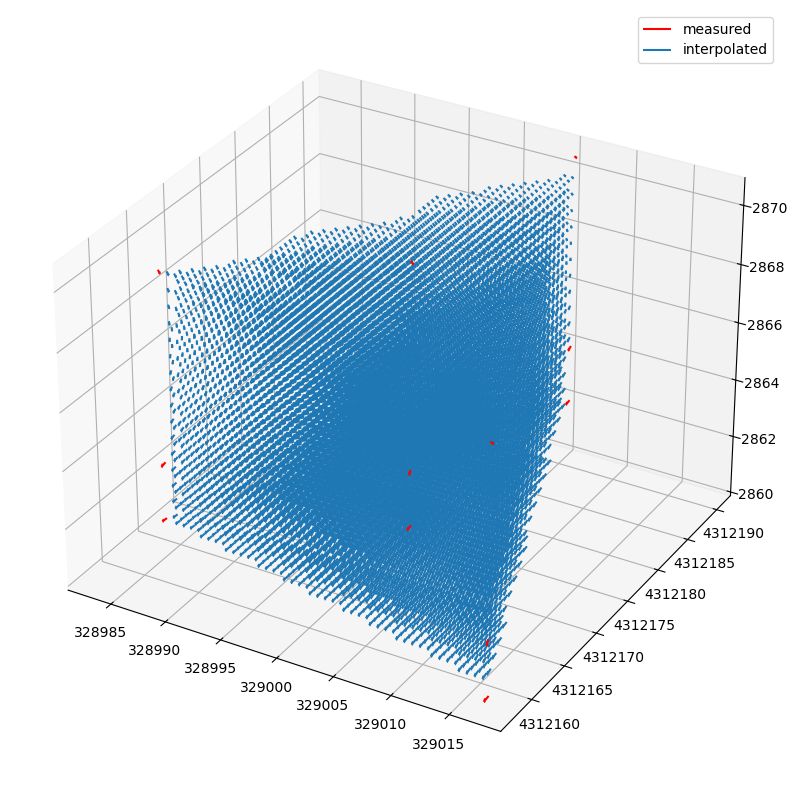

In [28]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

for i in [0]:
    wind_field_vals = pd.DataFrame(wind_field_df.iloc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    ax.quiver(
        points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z, 
        points_and_wind_fields.u, points_and_wind_fields.v, points_and_wind_fields.w,
        color='red', label='measured', pivot='middle'
    )
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.quiver(xx, yy, zz, u_interp, v_interp, w_interp, label='interpolated', pivot='middle')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.legend()

## 3D divergence calculations (volumetric)

In [29]:
def divergence(f,sp):
    """ Computes divergence of vector field 
    f: array -> vector field components [Fx,Fy,Fz,...]
    sp: array -> spacing between points in respecitve directions [spx, spy,spz,...]
    """
    num_dims = len(f)
    return np.ufunc.reduce(np.add, [np.gradient(f[i], sp[i], axis=i) for i in range(num_dims)])

In [30]:
points_and_wind_fields.z.max() - points_and_wind_fields.z.min()

10.617400000000089

# SHOULD I TRY TO COMPARE THIS WITH THE WAY I PERSONALLY CALCULATE DIVERGENCE??

In [31]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
mean_divergences_lateral_bylayer = []
mean_divergences_vertical_bylayer = []
for i in wind_field_df.index:
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]

    
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
    mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))

assert len(wind_field_df) == len(mean_divergences)
windfield_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=wind_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1627094382.py:49: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1627094382.py:49: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical_bylayer.append(np.nanmean(g_vertical,axis=(0,1)))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1627094382.py:48: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral_bylayer.append(np.nanmean(g_lateral,axis=(0,1)))
/var/folders/x_/2h52b

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/173837718.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/173837718.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/173837718.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


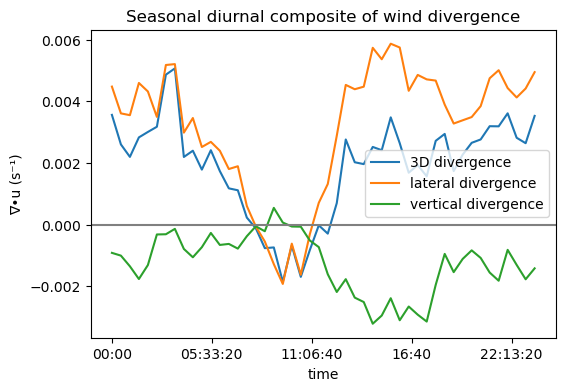

In [32]:
windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
windfield_div_df.mean_divergence_lateral.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
windfield_div_df.mean_divergence_vertical.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•u (s⁻¹)")
plt.title("Seasonal diurnal composite of wind divergence")
plt.legend()

In [33]:
src_lateral_bylayer = pd.DataFrame(mean_divergences_lateral_bylayer)
src_lateral_bylayer.index = wind_field_df.index

src_vertical_bylayer = pd.DataFrame(mean_divergences_vertical_bylayer)
src_vertical_bylayer.index = wind_field_df.index

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1113910705.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

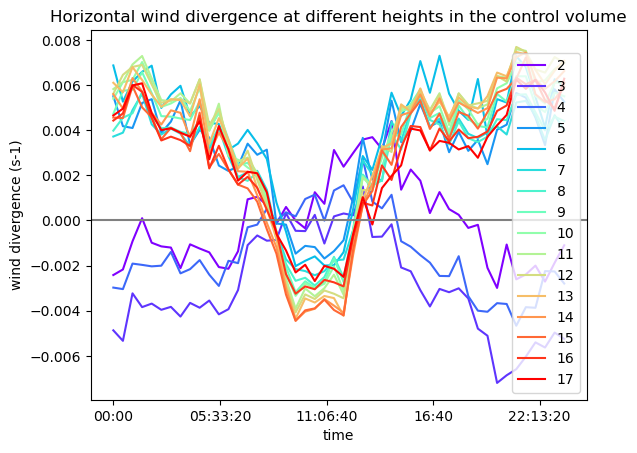

In [34]:
src = src_lateral_bylayer.groupby(src_lateral_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

In [35]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Horizontal wind divergence at different heights in the control volume')

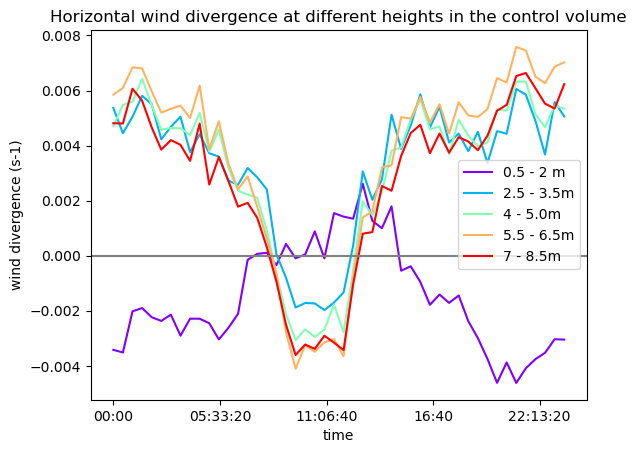

In [36]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Horizontal wind divergence at different heights in the control volume")

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/778491099.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)


Text(0.5, 1.0, 'Vertical wind divergence at different heights in the control volume')

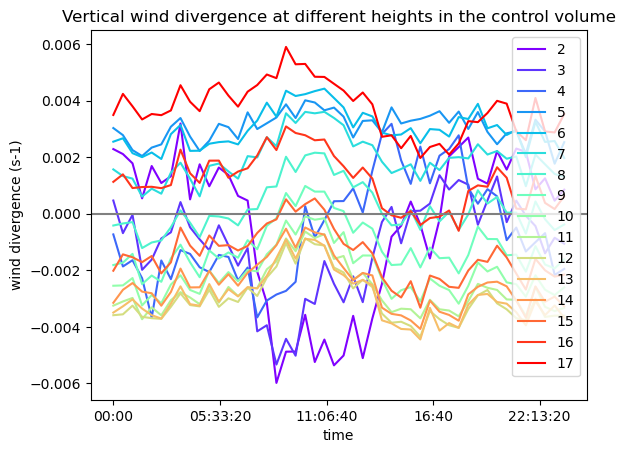

In [37]:
src = src_vertical_bylayer.groupby(src_vertical_bylayer.index.floor('30T').time).median().dropna(axis=1)
src.plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

In [38]:
src['0.5 - 2 m'] = np.mean(src[[2,3,4]], axis=1)
src['2.5 - 3.5m'] = np.mean(src[[5,6,7]], axis=1)
src['4 - 5.0m'] = np.mean(src[[8,9,10]], axis=1)
src['5.5 - 6.5m'] = np.mean(src[[11,12,13]], axis=1)
src['7 - 8.5m'] = np.mean(src[[14,15,16, 17]], axis=1)

Text(0.5, 1.0, 'Vertical wind divergence at different heights in the control volume')

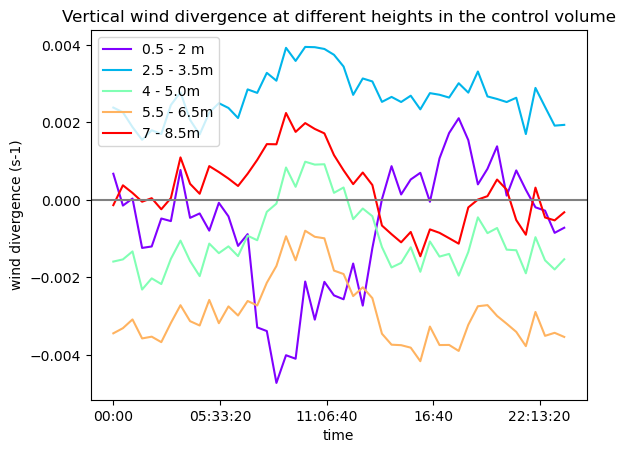

In [39]:
src[['0.5 - 2 m', '2.5 - 3.5m', '4 - 5.0m', '5.5 - 6.5m', '7 - 8.5m', ]].plot(colormap='rainbow')
plt.ylabel('wind divergence (s-1)')
plt.axhline(0, color='grey')
plt.title("Vertical wind divergence at different heights in the control volume")

## 3D divergence calculations (advected water vapor)

### Using form: $\frac{\partial}{\partial x_i} (u_i q) $

In [40]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in adv_flux_field_df.index:
    adv_flux_field_vals = pd.DataFrame(adv_flux_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    adv_flux_field_vals.columns = adv_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(adv_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(adv_flux_field_df) == len(mean_divergences)
adv_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=adv_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:41: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:42: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2068377316.py:43: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1853336912.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1853336912.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1853336912.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


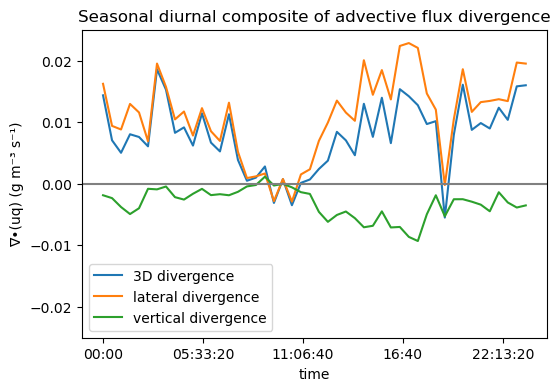

In [41]:
adv_flux_div_df.mean_divergence.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_df.mean_divergence_lateral.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_df.mean_divergence_vertical.groupby([adv_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.ylim(-0.025,0.025)
plt.legend()

### Using form: $u_i  \frac{\partial}{\partial x_i} (q) $
NOTE: we also calculate a absolute humidity (Storage) time series in this loop

In [42]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
abs_humidity_mean = []
windfields = []
divergencefields = []
for i in abs_hum_field_df.index:
    # Get abs. humidity data
    abs_humidity_field_vals = pd.DataFrame(abs_hum_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)
    points_and_abs_humidity_field = x.join(y).join(z).join(abs_humidity_field_vals, how='right')

    # Get wind field data
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    # Create meshgrid
    xx = np.linspace(
        points_and_abs_humidity_field.x.min(), 
        points_and_abs_humidity_field.x.max(), 50
    )
    yy = np.linspace(
        points_and_abs_humidity_field.y.min(), 
        points_and_abs_humidity_field.y.max(), 50
    )
    zz = np.linspace(
        points_and_abs_humidity_field.z.min(), 
        points_and_abs_humidity_field.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)

    # Get points
    points = np.transpose(np.vstack((points_and_abs_humidity_field.x, points_and_abs_humidity_field.y, points_and_abs_humidity_field.z)))

    # Interpolate abs. humidity field
    abs_humidity_interp = interpolate.griddata(points, points_and_abs_humidity_field['Water vapor density'], (xx, yy, zz), method='linear')

    # Interpolate wind field
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    # Create wind-field 3D array
    F_windfield = np.array([u_interp, v_interp, w_interp])
    F_windfield_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_windfield_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]

    dq_over_dx = np.gradient(abs_humidity_interp, axis=0)
    dq_over_dy = np.gradient(abs_humidity_interp, axis=1)
    dq_over_dz = np.gradient(abs_humidity_interp, axis=2)
    g_lateral = u_interp * dq_over_dx + v_interp * dq_over_dy
    g_vertical = w_interp * dq_over_dz
    g = g_lateral + g_vertical
    divergencefields.append(g)
    windfields.append(F_windfield)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))
    abs_humidity_mean.append(np.nanmean(abs_humidity_interp))

assert len(abs_hum_field_df) == len(mean_divergences)
adv_flux_div_method2_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical,
        'absolute humidity': abs_humidity_mean
    }, 
    index=abs_hum_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:65: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:66: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:67: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:68: RuntimeWarning: Mean of empty slice
  abs_humidity_mean.append(np.nanmean(abs_humidity_interp))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:65: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/461962973.py:66: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2164486644.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2164486644.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2164486644.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize

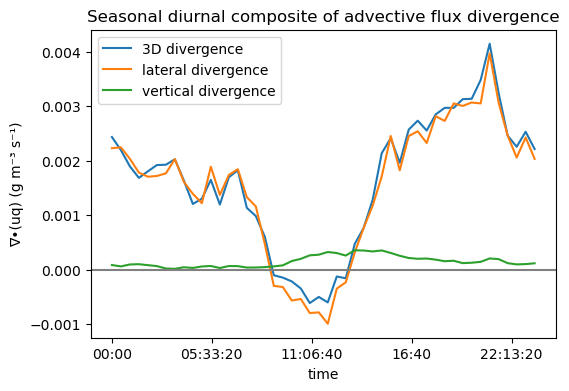

In [54]:
adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).median().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
# plt.ylim(-0.025,0.025)
plt.legend()

### Using form: $q \frac{\partial}{\partial x_i} (u_i) $
NOTE: we also calculate a absolute humidity (Storage) time series in this loop

In [44]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in abs_hum_field_df.index:
    # Get abs. humidity data
    abs_humidity_field_vals = pd.DataFrame(abs_hum_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    abs_humidity_field_vals.columns = abs_humidity_field_vals.columns.droplevel(0)
    points_and_abs_humidity_field = x.join(y).join(z).join(abs_humidity_field_vals, how='right')

    # Get wind field data
    wind_field_vals = pd.DataFrame(wind_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    wind_field_vals.columns = wind_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(wind_field_vals, how='right')

    # Create meshgrid
    xx = np.linspace(
        points_and_abs_humidity_field.x.min(), 
        points_and_abs_humidity_field.x.max(), 12
    )
    yy = np.linspace(
        points_and_abs_humidity_field.y.min(), 
        points_and_abs_humidity_field.y.max(), 12
    )
    zz = np.linspace(
        points_and_abs_humidity_field.z.min(), 
        points_and_abs_humidity_field.z.max(), 6
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)

    # Get points
    points = np.transpose(np.vstack((points_and_abs_humidity_field.x, points_and_abs_humidity_field.y, points_and_abs_humidity_field.z)))

    # Interpolate abs. humidity field
    abs_humidity_interp = interpolate.griddata(points, points_and_abs_humidity_field['Water vapor density'], (xx, yy, zz), method='linear')

    # Interpolate wind field
    u_interp = interpolate.griddata(points, points_and_wind_fields.u, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w, (xx, yy, zz), method='linear')

    # Create wind-field 3D array
    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = abs_humidity_interp * divergence(F, sp)
    g_lateral = abs_humidity_interp * divergence(F_lateral, sp)
    g_vertical = abs_humidity_interp * divergence(F_vertical, sp)
    
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(abs_hum_field_df) == len(mean_divergences)
adv_flux_div_method3_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical,
    }, 
    index=abs_hum_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:57: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:58: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:59: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.append(np.nanmean(g_vertical))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:57: RuntimeWarning: Mean of empty slice
  mean_divergences.append(np.nanmean(g))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:58: RuntimeWarning: Mean of empty slice
  mean_divergences_lateral.append(np.nanmean(g_lateral))
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1205047972.py:59: RuntimeWarning: Mean of empty slice
  mean_divergences_vertical.app

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1743636054.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1743636054.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence_lateral.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/1743636054.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method3_df.mean_divergence_vertical.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4)

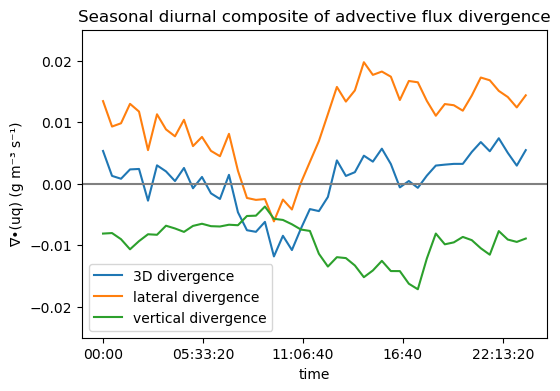

In [45]:
adv_flux_div_method3_df.mean_divergence.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method3_df.mean_divergence_lateral.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method3_df.mean_divergence_vertical.groupby([adv_flux_div_method3_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.ylim(-0.025,0.025)
plt.legend()

## Check out the mean diurnal cycle in windfields!!!

In [46]:
windfield_ds = xr.DataArray(windfields)
div_fields_ds = xr.DataArray(divergencefields)

windfield_ds = windfield_ds.rename({
    'dim_0': 'time',
    'dim_1': 'variable',
    'dim_2': 'x',
    'dim_3': 'y',  
    'dim_4': 'z',  
})
div_fields_ds = div_fields_ds.rename({
    'dim_0': 'time',
    'dim_1': 'x',
    'dim_2': 'y',  
    'dim_3': 'z',  
})

windfield_ds = windfield_ds.assign_coords({'time': abs_hum_field_df.index})
div_fields_ds = div_fields_ds.assign_coords({'time': abs_hum_field_df.index})

windfield_ds = xr.Dataset({
    'u': windfield_ds[:, 0, :, :, :],
    'v': windfield_ds[:, 1, :, :, :],
    'w': windfield_ds[:, 2, :, :, :],
    'div': div_fields_ds
})

windfield_ds.coords['hourminute'] = (
    ('time', ),
    pd.MultiIndex.from_arrays([
        np.array(windfield_ds.time.dt.hour),
        np.array(windfield_ds.time.dt.minute)
    ])
)

windfield_mean_ds = windfield_ds.groupby('hourminute').mean(dim='time')
windfield_mean_nobs_ds = windfield_ds.sel(time=windfield_ds.time.isin(nobs_times)).groupby('hourminute').mean(dim='time')

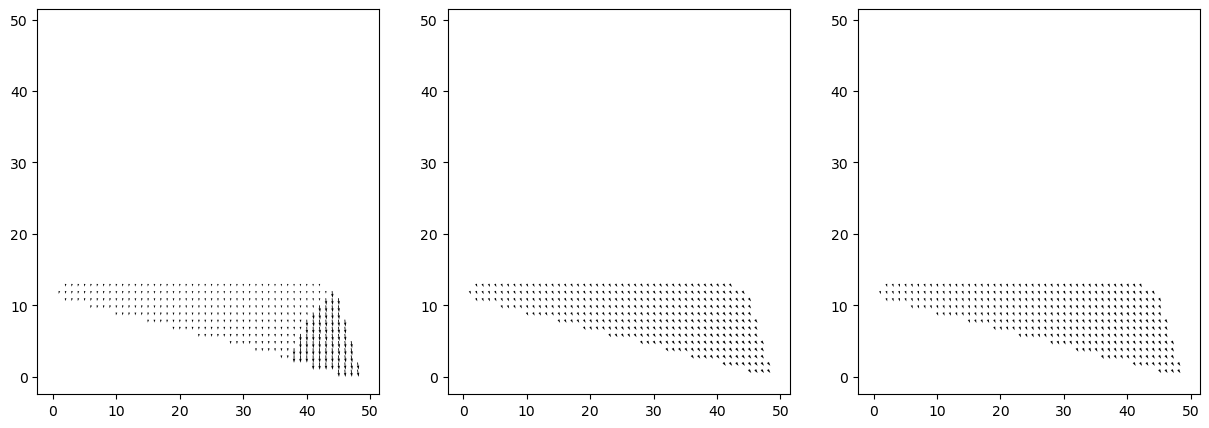

In [47]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].quiver(
    windfield_mean_ds.sel(hourminute=(10,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(10,30), z=1).v,
)
axes[1].quiver(
    windfield_mean_ds.sel(hourminute=(14,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(14,30), z=1).v,
)
axes[2].quiver(
    windfield_mean_ds.sel(hourminute=(22,30), z=1).x,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).y,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).u,
    windfield_mean_ds.sel(hourminute=(22,30), z=1).v,
)

# HERE

In [48]:
# GET WIND FIELDS
src = wind_field_df[wind_field_df.index.isin(nobs_times)].groupby(
    wind_field_df[wind_field_df.index.isin(nobs_times)].index.floor('30T').time
).mean()
src = pd.DataFrame(src.loc[dt.time(14)]).reset_index()
src = src.pivot_table(index=['height','tower'], columns='measurement', values=dt.time(14, 0)).join(
    instrument_loc_df
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/286292636.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  wind_field_df[wind_field_df.index.isin(nobs_times)].index.floor('30T').time


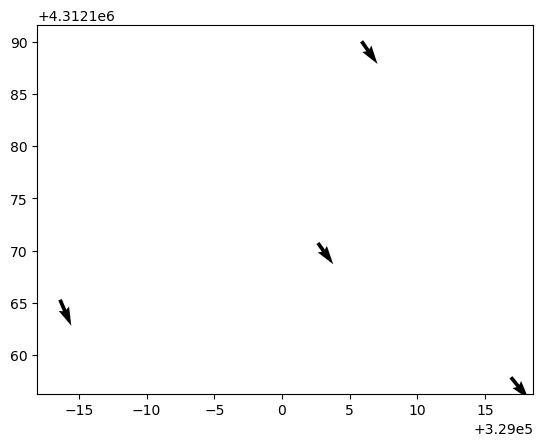

In [49]:
plt.quiver(src.loc[10].x, src.loc[10].y, src.loc[10].u, src.loc[10].v)

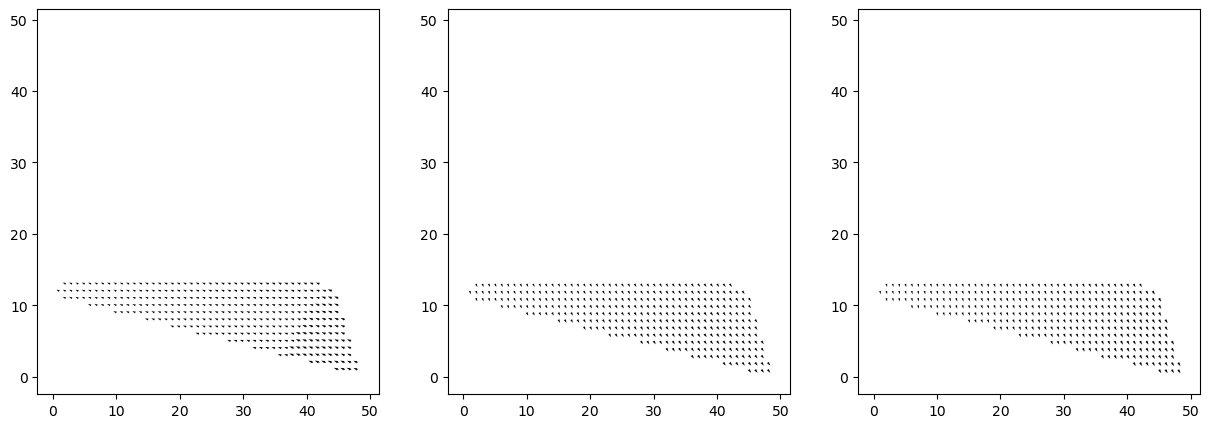

In [50]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(10,30), z=1).v,
)
axes[1].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(14,30), z=1).v,
)
axes[2].quiver(
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).x,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).y,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).u,
    windfield_mean_nobs_ds.sel(hourminute=(22,30), z=1).v,
)

/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/matplotlib/quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/Users/elischwat/miniforge3/envs/sublimationofsnow/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


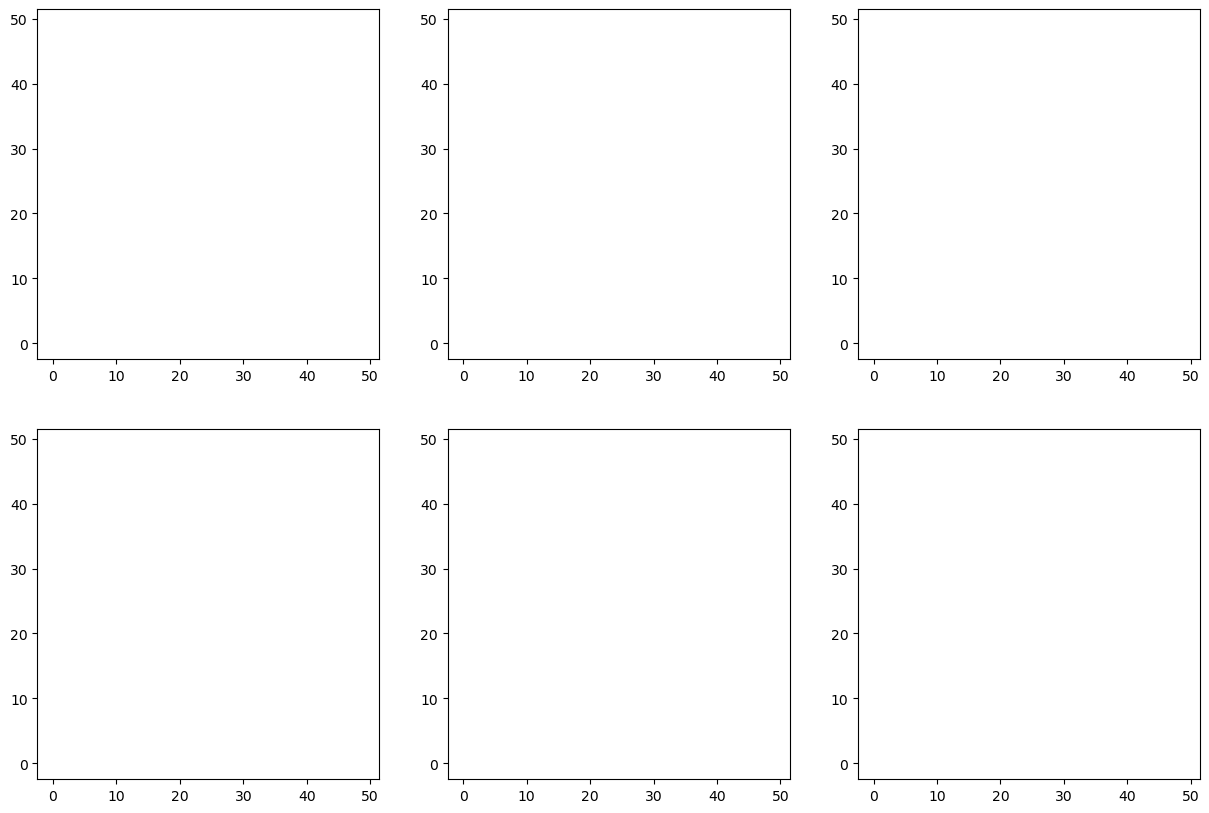

In [51]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[0,0].quiver(
    windfield_ds.sel(time='20230202 0600', z=1).x,
    windfield_ds.sel(time='20230202 0600', z=1).y,
    windfield_ds.sel(time='20230202 0600', z=1).u,
    windfield_ds.sel(time='20230202 0600', z=1).v,
)
axes[0,1].quiver(
    windfield_ds.sel(time='20230202 1200', z=1).x,
    windfield_ds.sel(time='20230202 1200', z=1).y,
    windfield_ds.sel(time='20230202 1200', z=1).u,
    windfield_ds.sel(time='20230202 1200', z=1).v,
)
axes[0,2].quiver(
    windfield_ds.sel(time='20230202 2000', z=1).x,
    windfield_ds.sel(time='20230202 2000', z=1).y,
    windfield_ds.sel(time='20230202 2000', z=1).u,
    windfield_ds.sel(time='20230202 2000', z=1).v,
)
axes[1,0].quiver(
    windfield_ds.sel(time='20230202 0600', z=2).x,
    windfield_ds.sel(time='20230202 0600', z=2).y,
    windfield_ds.sel(time='20230202 0600', z=2).u,
    windfield_ds.sel(time='20230202 0600', z=2).v,
)
axes[1,1].quiver(
    windfield_ds.sel(time='20230202 1200', z=2).x,
    windfield_ds.sel(time='20230202 1200', z=2).y,
    windfield_ds.sel(time='20230202 1200', z=2).u,
    windfield_ds.sel(time='20230202 1200', z=2).v,
)
axes[1,2].quiver(
    windfield_ds.sel(time='20230202 2000', z=2).x,
    windfield_ds.sel(time='20230202 2000', z=2).y,
    windfield_ds.sel(time='20230202 2000', z=2).u,
    windfield_ds.sel(time='20230202 2000', z=2).v,
)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12, 12, 6) and arg 3 with shape (50, 50, 20).

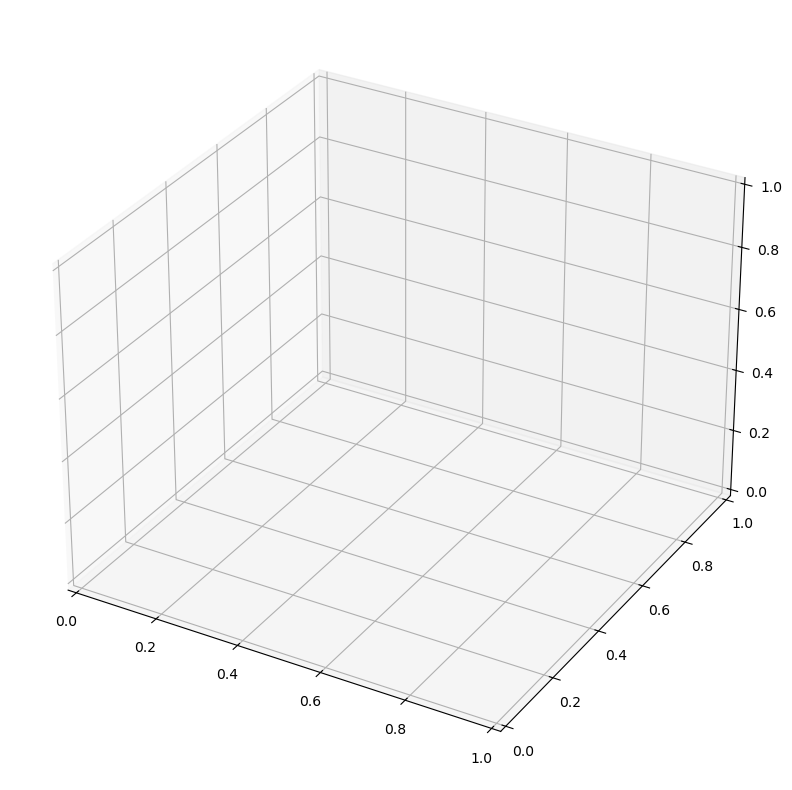

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation,FFMpegWriter

fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10,10))
ax.view_init(
    # elev=25, 
    # azim=-180, 
    # roll=0
)

def get_arrow(hourminute):
    """ hourminute should be something like (0,0) or (5, 30) or (21, 0)"""
    x = xx
    y = yy
    z = zz
    u = windfield_mean_nobs_ds['u'].sel(hourminute = hourminute)
    v = windfield_mean_nobs_ds['v'].sel(hourminute = hourminute)
    w = windfield_mean_nobs_ds['w'].sel(hourminute = hourminute)
    color = windfield_mean_nobs_ds['div'].sel(hourminute = hourminute)
    return x,y,z,u,v,w,color
x,y,z,u,v,w,color = get_arrow((0, 0))
c = (color.values.ravel() - np.nanmin(color)) / np.nanmax(color) - np.nanmin(color)
c = np.concatenate((c, np.repeat(c, 2)))
c.shape
c = plt.cm.jet(c)
# quiver = ax.quiver(x,y,z,u,v,w,colors=c)
quiver = ax.quiver(x,y,z,u,v,w)

ax.set_xlim(xx.min()-1, xx.max()+1)
ax.set_ylim(yy.min()-1, yy.max()+1)
ax.set_zlim(zz.min()-1, zz.max()+1)

def update(hourminute):
    global quiver
    quiver.remove()
    x,y,z,u,v,w,color = get_arrow(hourminute)
    c = (color.values.ravel() - np.nanmin(color)) / np.nanmax(color) - np.nanmin(color)
    c = np.concatenate((c, np.repeat(c, 2)))
    c.shape
    c = plt.cm.jet(c)
    # quiver = ax.quiver(x,y,z,u,v,w,colors=c)
    quiver = ax.quiver(x,y,z,u,v,w)
    ax.set_title(hourminute)

anim = FuncAnimation(
    fig, 
    update, 
    frames=sorted(windfield_mean_nobs_ds.hourminute.values),
    interval=250
)
plt.show()

In [ ]:
# Display animation with HTML
# video = anim.to_html5_video() # converting to an html5 video 
# html = display.HTML(video) # embedding for the video 
# display.display(html) # draw the animation 
# plt.close() 

# Save to file
writervideo = FFMpegWriter(fps=10) 
anim.save('increasingStraightLine.mp4', writer=writervideo) 
plt.close() 

In [ ]:
# for hrmin in windfield_mean_ds.hourminute:
#     fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10,10))
#     x = xx
#     y = yy
#     z = zz
#     u = windfield_mean_ds['u'].sel(hourminute = hrmin)
#     v = windfield_mean_ds['v'].sel(hourminute = hrmin)
#     w = windfield_mean_ds['w'].sel(hourminute = hrmin)
#     ax.quiver(*(x,y,z,u,v,w))
#     plt.show()

In [55]:
adv_flux_div_method2_df['storage_change'] = (adv_flux_div_method2_df['absolute humidity']).diff() / (60*30)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/965107178.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/965107178.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/965107178.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), l

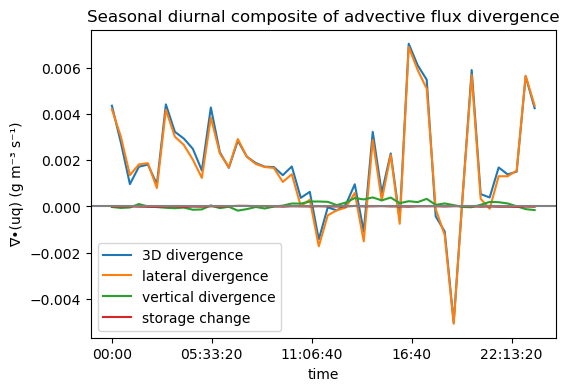

In [56]:
adv_flux_div_method2_df.mean_divergence.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
adv_flux_div_method2_df.mean_divergence_lateral.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
adv_flux_div_method2_df.mean_divergence_vertical.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
adv_flux_div_method2_df.storage_change.groupby([adv_flux_div_method2_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'storage change')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of advective flux divergence")
plt.legend()

## 3D divergence calculations (turb. diffused water vapor)

In [57]:
x = instrument_loc_df[['x']]
y = instrument_loc_df[['y']]
z = instrument_loc_df[['z']]

mean_divergences = []
mean_divergences_lateral = []
mean_divergences_vertical = []
for i in turb_flux_field_df.index:
    turb_flux_field_vals = pd.DataFrame(turb_flux_field_df.loc[i]).reset_index().set_index(['height', 'tower']).pivot(columns='measurement')
    turb_flux_field_vals.columns = turb_flux_field_vals.columns.droplevel(0)
    points_and_wind_fields = x.join(y).join(z).join(turb_flux_field_vals, how='right')

    xx = np.linspace(
        points_and_wind_fields.x.min(), 
        points_and_wind_fields.x.max(), 50
    )
    yy = np.linspace(
        points_and_wind_fields.y.min(), 
        points_and_wind_fields.y.max(), 50
    )
    zz = np.linspace(
        points_and_wind_fields.z.min(), 
        points_and_wind_fields.z.max(), 20
    )
    xx, yy, zz = np.meshgrid(xx, yy, zz)
    points = np.transpose(np.vstack((points_and_wind_fields.x, points_and_wind_fields.y, points_and_wind_fields.z)))
    u_interp = interpolate.griddata(points, points_and_wind_fields.u_h2o_, (xx, yy, zz), method='linear')
    v_interp = interpolate.griddata(points, points_and_wind_fields.v_h2o_, (xx, yy, zz), method='linear')
    w_interp = interpolate.griddata(points, points_and_wind_fields.w_h2o_, (xx, yy, zz), method='linear')

    F = np.array([u_interp, v_interp, w_interp])
    F_lateral = np.array([u_interp, v_interp, 0*w_interp])
    F_vertical = np.array([0*u_interp, 0*v_interp, w_interp])
    sp_x = np.diff(xx[0,:,0]).mean()
    sp_y = np.diff(yy[:,0,0]).mean()
    sp_z = np.diff(zz[0,0,:]).mean()
    sp = [sp_x, sp_y, sp_z]
    g = divergence(F, sp)
    g_lateral = divergence(F_lateral, sp)
    g_vertical = divergence(F_vertical, sp)
    mean_divergences.append(np.nanmean(g))
    mean_divergences_lateral.append(np.nanmean(g_lateral))
    mean_divergences_vertical.append(np.nanmean(g_vertical))

assert len(turb_flux_field_df) == len(mean_divergences)
turb_flux_div_df = pd.DataFrame({
        'mean_divergence': mean_divergences,
        'mean_divergence_lateral': mean_divergences_lateral,
        'mean_divergence_vertical': mean_divergences_vertical
    }, 
    index=turb_flux_field_df.index
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2277150821.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2277150821.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_23221/2277150821.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')


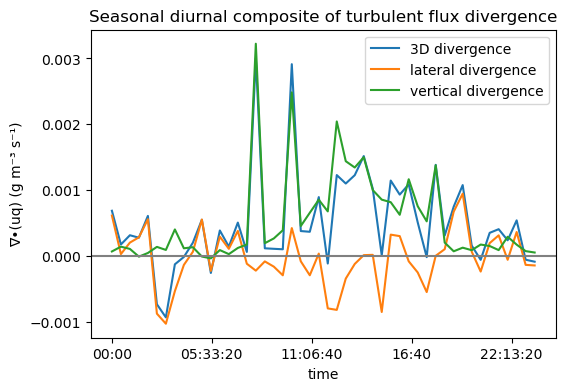

In [58]:
turb_flux_div_df.mean_divergence.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')
turb_flux_div_df.mean_divergence_lateral.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'lateral divergence')
turb_flux_div_df.mean_divergence_vertical.groupby([turb_flux_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = 'vertical divergence')
plt.axhline(0, color='grey')
plt.ylabel("∇•(uq) (g m⁻³ s⁻¹)")
plt.title("Seasonal diurnal composite of turbulent flux divergence")
plt.legend()

In [59]:
display(turb_flux_div_df.head())
display(adv_flux_div_df.head())
display(adv_flux_div_method2_df.head())
display(windfield_div_df.head())

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-01 00:00:00        -0.000139                -0.000023   
2022-11-01 00:30:00         0.000143                 0.000144   
2022-11-01 01:00:00         0.000072                 0.000128   
2022-11-01 01:30:00         0.000085                 0.000057   
2022-11-01 02:00:00         0.000114                 0.000137   

                     mean_divergence_vertical  
time                                           
2022-11-01 00:00:00             -1.161459e-04  
2022-11-01 00:30:00             -5.883050e-07  
2022-11-01 01:00:00             -5.678307e-05  
2022-11-01 01:30:00              2.806452e-05  
2022-11-01 02:00:00             -2.327389e-05

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-01 00:00:00        -0.009653                -0.003231   
2022-11-01 00:30:00         0.004974                 0.010238   
2022-11-01 01:00:00         0.006455                 0.016848   
2022-11-01 01:30:00         0.008034                 0.034019   
2022-11-01 02:00:00         0.003491                 0.037271   

                     mean_divergence_vertical  
time                                           
2022-11-01 00:00:00                 -0.006422  
2022-11-01 00:30:00                 -0.005264  
2022-11-01 01:00:00                 -0.010393  
2022-11-01 01:30:00                 -0.025986  
2022-11-01 02:00:00                 -0.033780

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-01 00:00:00         0.001276                 0.001327   
2022-11-01 00:30:00         0.005188                 0.005392   
2022-11-01 01:00:00         0.003348                 0.003708   
2022-11-01 01:30:00         0.003899                 0.004372   
2022-11-01 02:00:00         0.005056                 0.005426   

                     mean_divergence_vertical  absolute humidity  \
time                                                               
2022-11-01 00:00:00                 -0.000117           2.754510   
2022-11-01 00:30:00                 -0.000250           2.741750   
2022-11-01 01:00:00                 -0.000303           2.735786   
2022-11-01 01:30:00                 -0.000425           2.714227   
2022-11-01 02:00:00                 -0.000333           2.700695   

                     storage_change  
time                                 
2022-11-01 00:00:00             NaN  
2022-11-01 00:30:00       -0.000007  
2022-11-01 01:00:00       -0.000003  
2022-11-01 01:30:00       -0.000012  
2022-11-01 02:00:00       -0.000008

mean_divergence  mean_divergence_lateral  \
time                                                            
2022-11-01 00:00:00        -0.004174                -0.001977   
2022-11-01 00:30:00        -0.001469                 0.000206   
2022-11-01 01:00:00         0.000059                 0.003646   
2022-11-01 01:30:00         0.000443                 0.009623   
2022-11-01 02:00:00        -0.001995                 0.010162   

                     mean_divergence_vertical  
time                                           
2022-11-01 00:00:00                 -0.002198  
2022-11-01 00:30:00                 -0.001675  
2022-11-01 01:00:00                 -0.003587  
2022-11-01 01:30:00                 -0.009181  
2022-11-01 02:00:00                 -0.012157

# Plot all results

In [60]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
VOLUME = A4*7*units('m')
A1, A2, A3, A4, A5, VOLUME

(<Quantity(259, 'meter ** 2')>,
 <Quantity(259, 'meter ** 2')>,
 <Quantity(259, 'meter ** 2')>,
 <Quantity(580.2, 'meter ** 2')>,
 <Quantity(580.2, 'meter ** 2')>,
 <Quantity(4061.4, 'meter ** 3')>)

## Create combined dataset of all estimates

In [61]:
 # advective_stuff = adv_flux_div_method2_df.rename(columns={
advective_stuff = adv_flux_div_df.rename(columns={
    "mean_divergence": 'total advective flux divergence',
    "mean_divergence_lateral": 'lateral advective flux divergence',
    "mean_divergence_vertical": 'vertical advective flux divergence',
})[[
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence',
    # 'storage_change'
]]
advective_stuff.index = pd.to_datetime(advective_stuff.index)

turbulent_stuff = turb_flux_div_df.rename(columns={
    'mean_divergence': 'total turbulent flux divergence',
    'mean_divergence_lateral': 'lateral turbulent flux divergence',
    'mean_divergence_vertical': 'vertical turbulent flux divergence',
})
turbulent_stuff.index = pd.to_datetime(turbulent_stuff.index)

winddiv_stuff = windfield_div_df.rename(columns={
    'mean_divergence': 'total wind divergence',
    'mean_divergence_lateral': 'lateral wind divergence',
    'mean_divergence_vertical': 'vertical wind divergence',
})
winddiv_stuff.index = pd.to_datetime(winddiv_stuff.index)

combo_df = advective_stuff.merge(
    turbulent_stuff, left_index=True, right_index=True
).merge(
    winddiv_stuff, left_index=True, right_index=True
)

# combo_df = combo_df[combo_df.index.isin(nobs_times)]

combo_df_area_norm = combo_df.copy(deep=True)
combo_df_area_norm = combo_df_area_norm * 7
combo_df_area_norm = combo_df_area_norm.join(
    tidy_df[
        tidy_df.variable.isin(
            ['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c']
        )
    ].pivot(index='time', columns='variable', values='value').reset_index().set_index('time')
)
combo_df_area_norm = combo_df_area_norm.reset_index()

In [62]:
combo_df['storage_change'] = adv_flux_div_method2_df['storage_change']

## Plot divergences

In [63]:
adv_flux_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

turb_flux_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total turbulent flux divergence',
    'lateral turbulent flux divergence',
    'vertical turbulent flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^3/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

storagechange_chart = alt.Chart(combo_df.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(storage_change):Q').title('Divergence (g/m^3/s)'),
).properties(width=150, height = 150)

(
    adv_flux_chart | turb_flux_chart | storagechange_chart
).resolve_scale(color='independent', y='shared').configure_legend(orient='right', columns=1)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [64]:
adv_flux_chart = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'total advective flux divergence',
    'lateral advective flux divergence',
    'vertical advective flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

turb_flux_chart = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'total turbulent flux divergence',
    'lateral turbulent flux divergence',
    'vertical turbulent flux divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

storagechange_chart = alt.Chart(combo_df_area_norm.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(storage_change):Q').title('Divergence (g/m^2/s)'),
).properties(width=150, height = 150)

vert_turb_flux_3m = alt.Chart(combo_df_area_norm.reset_index()).transform_fold([
    'w_h2o__3m_c',
    'w_h2o__10m_c',
    'w_h2o__20m_c'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)

(
    adv_flux_chart | turb_flux_chart | storagechange_chart | vert_turb_flux_3m
).resolve_scale(color='independent', y='shared').configure_legend(orient='top', columns=1)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [65]:
wind_div_chart = alt.Chart(combo_df.reset_index()).transform_fold([
    'total wind divergence',
    'lateral wind divergence',
    'vertical wind divergence'
]).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(value):Q').title('Divergence (1/s)'),
    alt.Color('key:N')
).properties(width=150, height = 150)
wind_div_chart

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [66]:
alt.Chart(adv_flux_div_method2_df.reset_index()).mark_line().encode(
    alt.X('hours(time):T').title('time of day'),
    alt.Y('median(absolute humidity):Q').title('Divergence (1/s)')
).properties(width=150, height = 150)

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [67]:
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['w_h2o__3m_c', 'w_h2o__10m_c', 'w_h2o__20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("w'q' (g/m^2/s)"),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['airdensity_3m_c', 'airdensity_10m_c', 'airdensity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
    | 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['specifichumidity_3m_c', 'specifichumidity_10m_c', 'specifichumidity_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title("air density (kg/m^3)").scale(zero=False),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=250, height = 150) 
).resolve_scale(color='independent').configure_legend(orient='top').display(renderer='svg')

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


## Examine all terms in conservation of moisture eqxn

In [68]:
combo_df_area_norm['source'] = combo_df_area_norm['storage_change'] + combo_df_area_norm['total advective flux divergence'] + combo_df_area_norm['total turbulent flux divergence']

KeyError: 'storage_change'

In [ ]:
alt.Chart(
    combo_df_area_norm[(combo_df_area_norm.time > '20221221 1200') & (combo_df_area_norm.time < '20221223 1200')]
).transform_fold([
    'vertical advective flux divergence',
    'lateral advective flux divergence',
    'vertical turbulent flux divergence',
    'lateral turbulent flux divergence',
    'storage_change',
    'source'
]).mark_line().encode(
    alt.X('time:T').title('time of day'),
    alt.Y('value:Q').title('Divergence (g/m^2/s)'),
    alt.Color('key:N').title("term").sort([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ])
).properties(width=450, height = 300)

In [ ]:
def conservation_terms_plot(src):
    return alt.Chart(src).transform_fold([
        'total advective flux divergence',
        'total turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
        alt.Color('key:N').title("term")
    ).properties(width=150, height = 150)

def isin(df, list_of_timestamp_lists):
    if len(list_of_timestamp_lists) > 1:
        dates_intersection = [
            set(list_of_timestamp_lists[0]).intersection(l) for l in list_of_timestamp_lists[1:]
        ][0]
    else:
        dates_intersection = list_of_timestamp_lists[0]
    return df[df['time'].isin(dates_intersection)]

In [ ]:
(
    (
        conservation_terms_plot(combo_df_area_norm).properties(title='All data') |\
        conservation_terms_plot(isin(combo_df_area_norm, [nobs_times, is_not_snowing_dates])).properties(title='No BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [bs_times, is_not_snowing_dates])).properties(title='BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [is_snowing_dates])).properties(title='Is Snowing')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [december_times, nobs_times, is_not_snowing_dates])).properties(title='december (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [january_times, nobs_times, is_not_snowing_dates])).properties(title='january (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [february_times, nobs_times, is_not_snowing_dates])).properties(title='february (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [march_times, nobs_times, is_not_snowing_dates])).properties(title='march (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [april_times, nobs_times, is_not_snowing_dates])).properties(title='april (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 
    # & (
    #     conservation_terms_plot(isin(combo_df_area_norm, [december_times, bs_times, is_not_snowing_dates])).properties(title='december (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [january_times, bs_times, is_not_snowing_dates])).properties(title='january (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [february_times, bs_times, is_not_snowing_dates])).properties(title='february (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [march_times, bs_times, is_not_snowing_dates])).properties(title='march (BS, no snow)') |\
    #     conservation_terms_plot(isin(combo_df_area_norm, [april_times, bs_times, is_not_snowing_dates])).properties(title='april (BS, no snow)')
    # ).resolve_scale(x='shared', y='shared')
).configure_legend(orient='top').resolve_scale(x='shared', y='shared')

In [ ]:
def conservation_terms_plot(src):
    return alt.Chart(src).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('hours(time):T').title('time of day'),
        alt.Y('median(value):Q').title('Divergence (g/m^2/s)'),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=150, height = 150)

def isin(df, list_of_timestamp_lists):
    if len(list_of_timestamp_lists) > 1:
        dates_intersection = [
            set(list_of_timestamp_lists[0]).intersection(l) for l in list_of_timestamp_lists[1:]
        ][0]
    else:
        dates_intersection = list_of_timestamp_lists[0]
    return df[df['time'].isin(dates_intersection)]

In [ ]:
(
    (
        conservation_terms_plot(combo_df_area_norm).properties(title='All data') |\
        conservation_terms_plot(isin(combo_df_area_norm, [nobs_times, is_not_snowing_dates])).properties(title='No BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [bs_times, is_not_snowing_dates])).properties(title='BS, Not Snowing') |\
        conservation_terms_plot(isin(combo_df_area_norm, [is_snowing_dates])).properties(title='Is Snowing')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [december_times, nobs_times, is_not_snowing_dates])).properties(title='December (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [january_times, nobs_times, is_not_snowing_dates])).properties(title='January (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [february_times, nobs_times, is_not_snowing_dates])).properties(title='February (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [march_times, nobs_times, is_not_snowing_dates])).properties(title='March (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [april_times, nobs_times, is_not_snowing_dates])).properties(title='April (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') & (
        conservation_terms_plot(isin(combo_df_area_norm, [midwinter_times, nobs_times, is_not_snowing_dates])).properties(title='Winter (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [spring_times, nobs_times, is_not_snowing_dates])).properties(title='Spring (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 
).configure_legend(orient='top').resolve_scale(x='shared', y='shared').display(renderer='svg')

In [ ]:
(
        conservation_terms_plot(isin(combo_df_area_norm, [midwinter_times, nobs_times, is_not_snowing_dates])).properties(title='Winter (No BS or snow)') |\
        conservation_terms_plot(isin(combo_df_area_norm, [spring_times, nobs_times, is_not_snowing_dates])).properties(title='Spring (No BS or snow)')
    ).resolve_scale(x='shared', y='shared') 


# Explore hypothesis that water gathers above surface, is drained away by drainage winds

Is there an along-valley gradient in water vapor? (From the SPLASH sites + ARM sites?).

I wonder if it sublimates during the day but just sits in a layer above the snow, and then gets “washed” down valley with the night winds?

In [ ]:
src = tidy_df[tidy_df.variable.isin(['SnowDepth_c', 'RH_1m_c'])].pivot_table(
    index='time',
    columns='variable',
    values = 'value'
).reset_index()
src['1m_instrument_height'] =  1 - src['SnowDepth_c']
src['time_of_day'] = src['time'].apply(lambda dt: 'night' if dt.hour in [18,19,20,21,22,23,1,2,3,4,5] else 'day')
src = src.set_index('time')
alt.Chart(src.reset_index()).mark_circle(size=10).encode(
    alt.X('1m_instrument_height'),
    alt.Y('RH_1m_c'),
    alt.Facet('time_of_day')
)

In [ ]:
src = tidy_df[tidy_df.variable.isin(['SnowDepth_c', 'RH_1m_c', 'specifichumidity_1m_c'])].pivot_table(
    index='time',
    columns='variable',
    values = 'value'
).reset_index()
src['1m_instrument_height'] =  1 - src['SnowDepth_c']
src['1m instrument height bins'] = pd.cut(
    src['1m_instrument_height'], 
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1], 
    labels = ['0.0 - 0.2', '0.2 - 0.4', '0.4 -  0.6', '0.6 - 0.8', '0.8 - 1']
)
src = src.set_index('time')
src = src.groupby([src.index.floor('30T').time, '1m instrument height bins'])[['RH_1m_c', 'specifichumidity_1m_c', 'SnowDepth_c', '1m_instrument_height']].mean().reset_index()
src['time_of_day'] = src['level_0'].apply(lambda tim: dt.datetime.combine(
    dt.datetime(2024, 2, 15),
    tim
))
(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=300, height = 100) & 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T").axis(None),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=300, height = 100) & 
    (
        alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('specifichumidity_1m_c'),
            alt.Color('1m instrument height bins:O').scale(scheme='greys').title(['Instrument height above snow', '(Specific Humidity)']),
            # alt.StrokeDash('1m instrument height bins:O'),
        ) + alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('RH_1m_c'),
            alt.Color('1m instrument height bins:O').scale(scheme='blues').title(['Instrument height above snow', '(Relative Humidity)']),
            # alt.StrokeDash('1m instrument height bins:O'),
        )
    ).resolve_scale(y='independent', color='independent')
).resolve_scale(y='independent', color='independent')

In [ ]:
src1 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_1m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src1['instrument_height'] =  1 - src1['SnowDepth_c']
src1 = src1.rename(columns={'specifichumidity_1m_c': 'specifichumidity'})

src2 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_2m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src2['instrument_height'] =  2 - src2['SnowDepth_c']
src2 = src2.rename(columns={'specifichumidity_2m_c': 'specifichumidity'})

src3 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_3m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src3['instrument_height'] =  3 - src3['SnowDepth_c']
src3 = src3.rename(columns={'specifichumidity_3m_c': 'specifichumidity'})

src4 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_4m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src4['instrument_height'] =  4 - src4['SnowDepth_c']
src4 = src4.rename(columns={'specifichumidity_4m_c': 'specifichumidity'})

src5 = tidy_df[tidy_df.variable.isin([
    'SnowDepth_c', 
    'specifichumidity_5m_c'
])].pivot_table(
    index='time',
    columns=['variable',],
    values = 'value'
).reset_index()
src5['instrument_height'] =  5 - src5['SnowDepth_c']
src5 = src5.rename(columns={'specifichumidity_5m_c': 'specifichumidity'})

src = pd.concat([src1,src2,src3,src4,src5])
bin_min = 0
bin_max = 5
steps = 26
src['instrument height bins'] = pd.cut(
    src['instrument_height'], 
    bins = np.linspace(bin_min, bin_max, steps), 
    labels = np.linspace(bin_min, bin_max, steps)[:-1] + 0.5*(bin_max/(steps-1))
)
src = src.set_index('time')
src = src.groupby([src.index.floor('30T').time, 'instrument height bins'])[['specifichumidity', 'SnowDepth_c', 'instrument_height']].mean().reset_index()
src['time_of_day'] = src['level_0'].apply(lambda tim: dt.datetime.combine(
    dt.datetime(2024, 2, 15),
    tim
))

(
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=300, height = 100) & 
    alt.Chart(
        tidy_df[tidy_df.variable.isin(['Rnet_9m_d', 'Rsw_in_9m_d',])]
    ).mark_line().encode(
        alt.X("hours(time):T").axis(None),
        alt.Y("median(value):Q").title('Radiation (W/m^2)'),
        alt.Color('measurement:N')
    ).properties(width=300, height = 100) & 
    (
        alt.Chart(src).mark_line().encode(
            alt.X('time_of_day:T'),
            alt.Y('specifichumidity'),
            alt.Color('instrument height bins:O').scale(scheme='purpleorange').title(['Instrument height above snow', '(Specific Humidity)']),
            # alt.StrokeDash('instrument height bins:O'),
        )
    ).resolve_scale(y='independent', color='independent')
).resolve_scale(y='independent', color='independent')

In [ ]:
alt.Chart(
        tidy_df[tidy_df.variable.isin(['dir_3m_c', 'dir_10m_c', 'dir_20m_c'])]
    ).mark_line().encode(
        alt.X("hours(time):T"),
        alt.Y("median(value):Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        # alt.Color('height:O').scale(scheme='greys'),
        alt.Color("month(time):O").sort(['Nov', 'Dec']).scale(scheme='turbo')
    ).properties(width=300, height = 100)

In [ ]:

windfield_div_df.mean_divergence.groupby([windfield_div_df.index.floor('30T').time]).mean().plot(figsize=(6,4), label = '3D divergence')

In [ ]:
fig, axes = plt.subplots(3,1, sharex=True)
tidy_df.query("variable == 'SnowDepth_c'").set_index('time')['value'].plot(ax=axes[0])
tidy_df.query("variable == 'RH_1m_c'").set_index('time')['value'].plot(ax=axes[1])
plt.tight_layout()

In [ ]:
is_snowing_dates[is_snowing_dates.dt.month == 2].dt.day.unique()

In [ ]:
src = tidy_df[(tidy_df.time > '20230201') & (tidy_df.time < '20230204')]
# src = tidy_df[(tidy_df.time > '20221216') & (tidy_df.time < '20221221')]


In [ ]:
alt.Chart(
    src.query("variable == 'SnowDepth_d'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200, 
             title=f"Mean depth: {round(src.query("variable == 'SnowDepth_d'").value.mean(), 2)}m"
            )

In [ ]:
alt.Chart(
    src.query("variable == 'SnowDepth_c'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200, 
             title=f"Mean depth: {round(src.query("variable == 'SnowDepth_c'").value.mean(), 2)}m"
            )

In [ ]:
alt.Chart(
    src.query("variable == 'SF_avg_ue'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q").title('BS Flux (g/m^s/2)'),
    alt.Color('height:O').scale(scheme='greys')
).properties(width=400, height = 200)

In [ ]:
windstart_df = src.query("variable == 'Rsw_in_9m_d'")
windstart_df = windstart_df[(windstart_df.time.dt.hour == 9) & (windstart_df.time.dt.minute == 0)]
windend_df = src.query("variable == 'Rsw_in_9m_d'")
windend_df = windend_df[(windend_df.time.dt.hour == 15) & (windend_df.time.dt.minute == 30)]
(
    alt.Chart(windstart_df).mark_rule().encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule().encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.query("measurement == 'wind direction'").query("tower == 'c'").query("height > 1")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Wind direction (˚)').scale(domain=[0,360]).axis(values=[0,90, 180,270,360]),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=800, height = 200)
).configure_axis(grid=False)

In [ ]:
sunrise_df = src.query("variable == 'Rsw_in_9m_d'")
sunrise_df = sunrise_df[(sunrise_df.time.dt.hour == 7) & (sunrise_df.time.dt.minute == 0)]
sunset_df = src.query("variable == 'Rsw_in_9m_d'")
sunset_df = sunset_df[(sunset_df.time.dt.hour == 17) & (sunset_df.time.dt.minute == 0)]
(
    alt.Chart(sunrise_df).mark_rule(color='yellow').encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='yellow').encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.query("variable == 'Rsw_in_9m_d'")
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Incoming Rsw (W/m^2)'),
        alt.Color('height:O').scale(scheme='greys')
    ).properties(width=800, height = 200)
).configure_axis(grid=False)

In [ ]:
(        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'temperature'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Temperature (˚C)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(temperature)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent')

In [ ]:
hum_chart = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'specific humidity'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Specific humidity (g/g)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(specific humidity)'])
    ).properties(width=800, height = 200)
    +
    alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'RH'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Relative humidity (%)'),
        alt.Color("height:O").scale(scheme='reds').title(['Height','(relative humidity)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
    title='Relative and specific humidity measurements from tower C, height adjusted to snow depth'
)

In [ ]:
temp_chart = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
            pd.concat([
                src.assign(height = src.height - 0.88).query("measurement == 'snow temperature'").query("tower =='d'").query("height > 0.12"),
                src.assign(height = src.height - 0.66).query("measurement == 'temperature'").query("height > 0").query("height < 4")
            ])
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Temperature (˚C)'),
        alt.Color("height:O").scale(scheme='blues').title(['Height','(temperature)']),
        tooltip='height'
    ).properties(width=800, height = 200)
).resolve_scale(
    y='independent', 
    color='independent',
).properties(
    title='Combined temperature measurements from tower D thermistors and tower C thermometers, height adjusted to snow depth'
)

In [ ]:
temp_chart & hum_chart 

In [ ]:
from metpy import calc
from metpy.units import units

In [ ]:
units.millibar

In [ ]:
w_w_ = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'w_w_'").query("height > 0").query("tower == 'c' ").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title("<w'w'> (m^2/s^2)"),
        alt.Color("height:O").scale(scheme='blues').title("Height (m)"),
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
)

In [ ]:
windspeed = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'wind speed'").query("height > 0").query("tower == 'c' ").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O").scale(scheme='blues').title(['Height (m)']),
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
)

In [ ]:
ri = (
    
alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(
    src.assign(height = src.height - 0.66).query(
        "measurement == 'richardson number'"
    ).query("height > 0").query("tower == 'c' ").query("height < 4")
).mark_line().encode(
    alt.X('time:T'),
    alt.Y("value:Q").title("Ri").scale(type='symlog', domain=[-100,100], clamp=True).axis(values=[-1, -10, -100, 0.1, 1, 10, 100]),
    alt.Color("height:O").scale(scheme='blues'),
).properties(width=800, height = 200))

In [ ]:
airdensity = (        
    alt.Chart(sunrise_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(sunset_df).mark_rule(color='orange', strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windstart_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + alt.Chart(windend_df).mark_rule(strokeWidth=2).encode(
        alt.X('time:T')
    ) + 
    alt.Chart(
        src.assign(height = src.height - 0.66).query("measurement == 'air density'").query("height > 0").query("height < 4")
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y("value:Q").title('Air density (kg/m^3)').scale(zero=False),
        alt.Color("height:O").title(['Height (m)'])
    ).properties(width=800, height = 200)
).resolve_scale(y='independent', color='independent').properties(
    
)

In [ ]:

(
    alt.Chart(
        combo_df_area_norm[(combo_df_area_norm.time > '20230201') & (combo_df_area_norm.time < '20230204')]
    ).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('time:T').title('time of day'),
        alt.Y('value:Q').title('Divergence (g/m^2/s)').scale(domain=[-0.2,0.2], clamp=True),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=800, height = 200)
    &
    temp_chart & hum_chart & airdensity.properties(height = 150
    ) & ri.properties(height = 150
    ) & windspeed.properties(height = 150
    ) & w_w_.properties(height = 150
    )).resolve_scale(color='independent', x='shared', y='independent')

In [ ]:
def month_series(src):
    return alt.Chart(
        src
    ).transform_fold([
        'vertical advective flux divergence',
        'lateral advective flux divergence',
        'vertical turbulent flux divergence',
        'lateral turbulent flux divergence',
        'storage_change',
        'source'
    ]).mark_line().encode(
        alt.X('time:T').title('time of day'),
        alt.Y('value:Q').title('Divergence (g/m^2/s)').scale(domain=[-0.2,0.2], clamp=True),
        alt.Color('key:N').title("term").sort([
            'vertical advective flux divergence',
            'lateral advective flux divergence',
            'vertical turbulent flux divergence',
            'lateral turbulent flux divergence',
            'storage_change',
            'source'
        ])
    ).properties(width=800, height = 200)

In [ ]:
month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20221201') & (combo_df_area_norm.time < '20221231')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230101') & (combo_df_area_norm.time < '20230131')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230201') & (combo_df_area_norm.time < '20230228')]
) & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230301') & (combo_df_area_norm.time < '20230331')]
)  & month_series(
    combo_df_area_norm[(combo_df_area_norm.time > '20230401') & (combo_df_area_norm.time < '20230430')]
)

In [ ]:
def scat(height_tower_str = '3m_c'):
    return alt.Chart(
        tidy_df[tidy_df.measurement.isin(['u','v'])].pivot(index='time', columns='variable', values='value').reset_index()
    ).mark_circle(color='black', size=1).encode(
        alt.X(f"u_{height_tower_str}:Q").scale(domain=[-6, 6], clamp=True), 
        alt.Y(f"v_{height_tower_str}:Q").scale(domain=[-6, 6], clamp=True)
    ).properties(width=150, height = 150)

In [ ]:
(scat('1m_c') | scat('2m_c') | scat('3m_c')| scat('5m_c') | scat('10m_c') | scat('15m_c')| scat('20m_c')).resolve_scale(x='shared', y='shared')

In [ ]:
(
    (scat('1m_c') & scat('3m_c') & scat('10m_c')).resolve_scale(x='shared', y='shared') |
    (scat('1m_d') & scat('3m_d') & scat('10m_d')).resolve_scale(x='shared', y='shared') |
    (scat('1m_ue') & scat('3m_ue') & scat('10m_ue')).resolve_scale(x='shared', y='shared') |
    (scat('1m_uw') & scat('3m_uw') & scat('10m_uw')).resolve_scale(x='shared', y='shared')   
).resolve_scale(x='shared', y='shared')

### Is there a consistent moisture gradient across our site?

In [ ]:
src

In [ ]:
# plot diurnal signal in gas analyzer abs. humidity measurements
src = tidy_df.query("measurement == 'Water vapor density'")
src = src[src.height.isin([3,10])]
src = src[src.time.isin(nobs_times)]
src = src[src.time.isin(is_not_snowing_dates)]
alt.Chart(
    src
).mark_line().encode(
    alt.X('hours(time):T'),
    alt.Y('mean(value):Q').title('Abs. humidity (g/m^3)').scale(zero=False),
    alt.Color("tower:N"),
    alt.StrokeDash('height:O')
).properties(
    title=['Composite (mean) diurnal cycle in humidity',
           'as measured by post-calibrated gas analyzers']
)

# Compare with results from the Control Volume approach

In [ ]:
cv_df = pd.read_csv('flux_divergence_3d_control_volume.csv').set_index('time')
cv_df.index = pd.to_datetime(cv_df.index)
cv_df.columns[-16:]

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_turb_divergence (g/s)'].plot()
turb_flux_div_df.groupby(turb_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
cv_df.groupby(cv_df.index.floor('30T').time).mean()['total_adv_divergence (g/s)'].plot()
adv_flux_div_df.groupby(adv_flux_div_df.index.floor('30T').time).mean()['mean_divergence'].plot()

In [ ]:
zz.max() - zz.min()

In [ ]:
cv_df.head()

In [ ]:

windfield_div_df